## Film Content Insights



## Overview

This project analyzes current trends in the film industry by examining the performance of different genres at the box office. By investigating various datasets, including Box Office Mojo, IMDB, Rotten Tomatoes, TheMovieDB, and The Numbers, we aim to identify what types of films are currently most successful. This analysis will help in forecasting which film genres hold the most promise for profitability and audience engagement, thus guiding strategic decisions related to film production, marketing, and distribution.

## Business Problem

The film industry is highly competitive and continuously evolving, with varying audience preferences and technological advancements shaping market dynamics. Understanding which film genres are performing well at the box office can enable the newly established movie studio to allocate resources effectively, maximize returns, and expand its market presence. By leveraging detailed box office data, the studio can make informed decisions about which types of films to produce, potentially leading to increased profitability and audience acclaim.

<img src="https://wallpapercave.com/wp/wp8021237.jpg" width="300" alt="Descriptive Text">


## Data Understanding

The datasets include a mix of structured data from well-known film databases, covering extensive details about film genres, box office earnings, ratings, and audience feedback across several years. Each film is identified uniquely, allowing for precise tracking of its performance from release to international earnings. This comprehensive data enables an in-depth analysis of market trends, audience preferences, and financial outcomes associated with different film types.

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import numpy as np




# Setting visualisation styles
sns.set(style="whitegrid")


# Load TSV files
rt_movie_info = pd.read_csv(r'C:\Users\neali\Documents\Flatiron\2\dsc-phase-2-project\zippedData\rt.movie_info.tsv.gz', delimiter='\t', compression='gzip')
# Load TSV files using latin-1 encoding
rt_reviews = pd.read_csv(
    r'C:\Users\neali\Documents\Flatiron\2\dsc-phase-2-project\zippedData\rt.reviews.tsv.gz',
    delimiter='\t',
    compression='gzip',
    encoding='latin-1'
)


# Load CSV files
bom_movie_gross = pd.read_csv(r'C:\Users\neali\Documents\Flatiron\2\dsc-phase-2-project\zippedData\bom.movie_gross.csv.gz', compression='gzip')
tmdb_movies = pd.read_csv(r'C:\Users\neali\Documents\Flatiron\2\dsc-phase-2-project\zippedData\tmdb.movies.csv.gz', compression='gzip')
tn_movie_budgets = pd.read_csv(r'C:\Users\neali\Documents\Flatiron\2\dsc-phase-2-project\zippedData\tn.movie_budgets.csv.gz', compression='gzip')
directors_df = pd.read_csv('the_oscar_award.csv')



# Path to the zip file
zip_file_path = r'C:\Users\neali\Documents\Flatiron\2\phase-2-project-v3\dsc-phase-2-project-v3\zippedData\im.db.zip'
# Directory where the db file will be extracted
extraction_path = r'C:\Users\neali\Documents\Flatiron\2\phase-2-project-v3\dsc-phase-2-project-v3\zippedData'

# Unzip the database file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents into the directory
    zip_ref.extractall(extraction_path)

# Assuming the database file is named 'im.db' and is the only file in the zip
db_file_path = os.path.join(extraction_path, 'im.db')

# Connect to the SQLite database
conn = sqlite3.connect(db_file_path)

# Now you can perform database operations
# Example: Listing all tables
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
for table in tables:
    print(table)





# Querying data from SQLite database
query = """
SELECT *
FROM movie_basics
JOIN movie_ratings ON movie_basics.movie_id = movie_ratings.movie_id;
"""
movie_data = pd.read_sql_query(query, conn)

('movie_basics',)
('directors',)
('known_for',)
('movie_akas',)
('movie_ratings',)
('persons',)
('principals',)
('writers',)


## Data Processing with Pandas and SQLite

Next, we will perform a series of SQL and Pandas operations to retrieve and process data from the IMDB movie database, focusing on movie ratings and related attributes. The top 20 unique ratings are displayed, showcasing key information about each movie, including its title, director, character involvement, average rating, and total votes. This data is particularly useful for analyzing viewer preferences and the impact of directorial roles on movie ratings.

In [2]:
#Combine Data
sql_query2 = """

SELECT 
    mb.primary_title, 
    p.primary_name, 
    mb.start_year,
    mb.genres,
    mr.averagerating,
    mr.numvotes
FROM 
    movie_basics mb
JOIN 
    directors d ON mb.movie_id = d.movie_id
JOIN 
    persons p ON d.person_id = p.person_id
JOIN 
    principals pr ON p.person_id = pr.person_id
JOIN 
    movie_ratings mr ON mb.movie_id = mr.movie_id
GROUP BY 
    mb.movie_id, p.primary_name
ORDER BY 
    mb.movie_id ASC;
"""



# Assuming 'conn' is already your active connection to the SQLite database
result = pd.read_sql_query(sql_query2, conn)
result.head()



# Drop duplicates based on 'primary_title' and 'averagerating'
# Explicitly create a copy after dropping duplicates to avoid SettingWithCopyWarning in future operations
unique_ratings = result.drop_duplicates(subset=['primary_title', 'averagerating']).copy()

# Sort the DataFrame by 'numvotes' in descending order
sorted_unique_ratings = unique_ratings.sort_values(by='numvotes', ascending=False)

# Select the top 20 unique ratings
top_20_unique_ratings = sorted_unique_ratings.head(20)

# Display the top 20 unique ratings
top_20_unique_ratings









,primary_title,primary_name,start_year,genres,averagerating,numvotes
2635,Inception,Christopher Nolan,2010,"Action,Adventure,Sci-Fi",8.8,1841066
2471,The Dark Knight Rises,Christopher Nolan,2012,"Action,Thriller",8.4,1387769
303,Interstellar,Christopher Nolan,2014,"Adventure,Drama,Sci-Fi",8.6,1299334
13717,Django Unchained,Quentin Tarantino,2012,"Drama,Western",8.4,1211405
352,The Avengers,Joss Whedon,2012,"Action,Adventure,Sci-Fi",8.1,1183655
555,The Wolf of Wall Street,Martin Scorsese,2013,"Biography,Crime,Drama",8.2,1035358
1175,Shutter Island,Martin Scorsese,2010,"Mystery,Thriller",8.1,1005960
17491,Guardians of the Galaxy,James Gunn,2014,"Action,Adventure,Comedy",8.1,948394
3117,Deadpool,Tim Miller,2016,"Action,Adventure,Comedy",8.0,820847
2782,The Hunger Games,Gary Ross,2012,"Action,Adventure,Sci-Fi",7.2,795227


Next, we will read and analyze the CSV and TSV files in order to then merge and perform analysis with the queried database

In [3]:
# List columns of each DataFrame
dataframes = {
    'RT Movie Info': rt_movie_info,
    'RT Reviews': rt_reviews,
    'BOM Movie Gross': bom_movie_gross,
    'TMDB Movies': tmdb_movies,
    'TN Movie Budgets': tn_movie_budgets,
    'Director Info': directors_df
}

# Print columns for each DataFrame
for name, df in dataframes.items():
    print(f"Columns in {name}:")
    print(df.columns.tolist())
    print()


Columns in RT Movie Info:
['id', 'synopsis', 'rating', 'genre', 'director', 'writer', 'theater_date', 'dvd_date', 'currency', 'box_office', 'runtime', 'studio']

Columns in RT Reviews:
['id', 'review', 'rating', 'fresh', 'critic', 'top_critic', 'publisher', 'date']

Columns in BOM Movie Gross:
['title', 'studio', 'domestic_gross', 'foreign_gross', 'year']

Columns in TMDB Movies:
['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title', 'popularity', 'release_date', 'title', 'vote_average', 'vote_count']

Columns in TN Movie Budgets:
['id', 'release_date', 'movie', 'production_budget', 'domestic_gross', 'worldwide_gross']

Columns in Director Info:
['year_film', 'year_ceremony', 'ceremony', 'category', 'name', 'film', 'winner']



## Analysis 1: Find ROI for highest grossing movies based on Genre

The next step is to merge dataframes in order to see highest grossing and viewed films, then create a new column calculating the Return on Investment (ROI) and finally, sort and group by Genre.

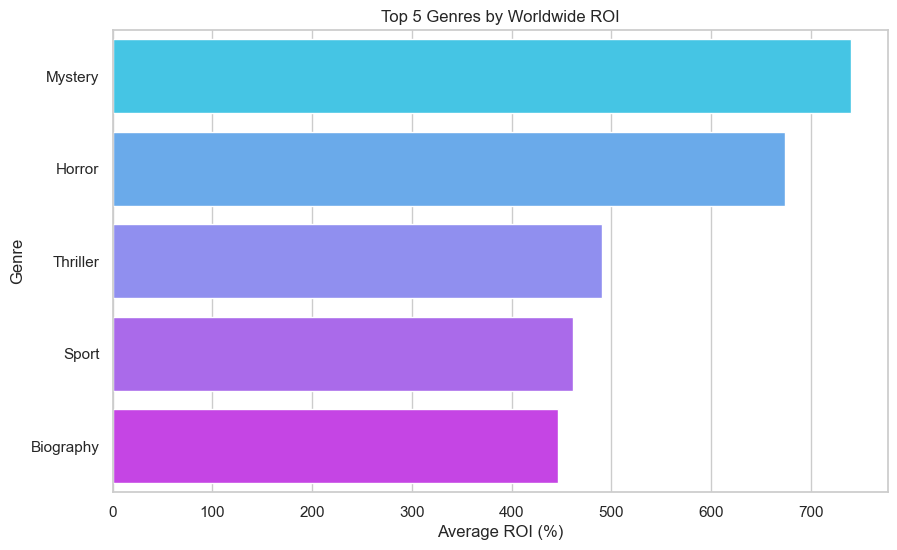

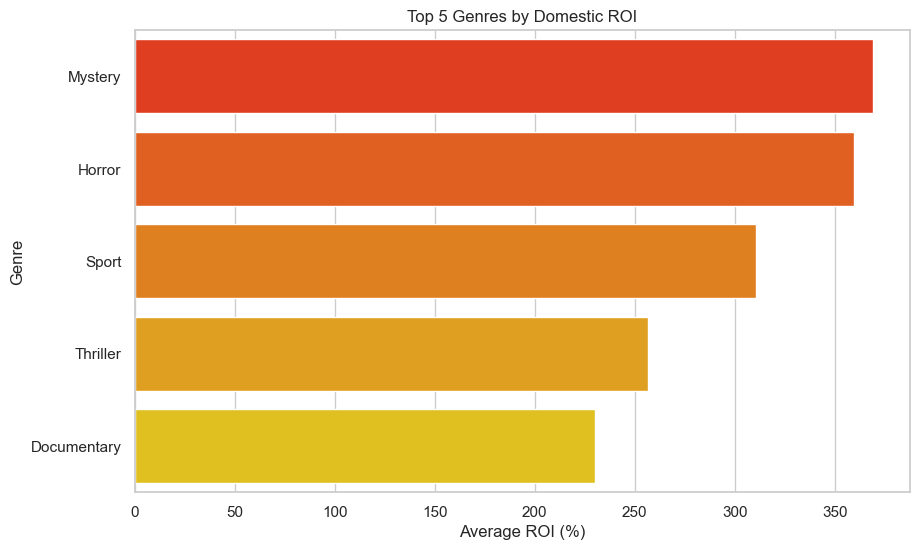

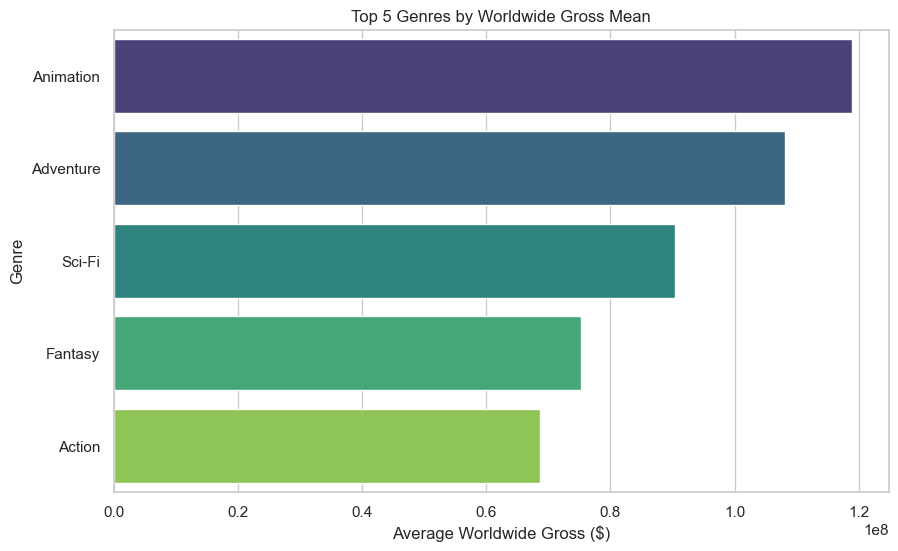

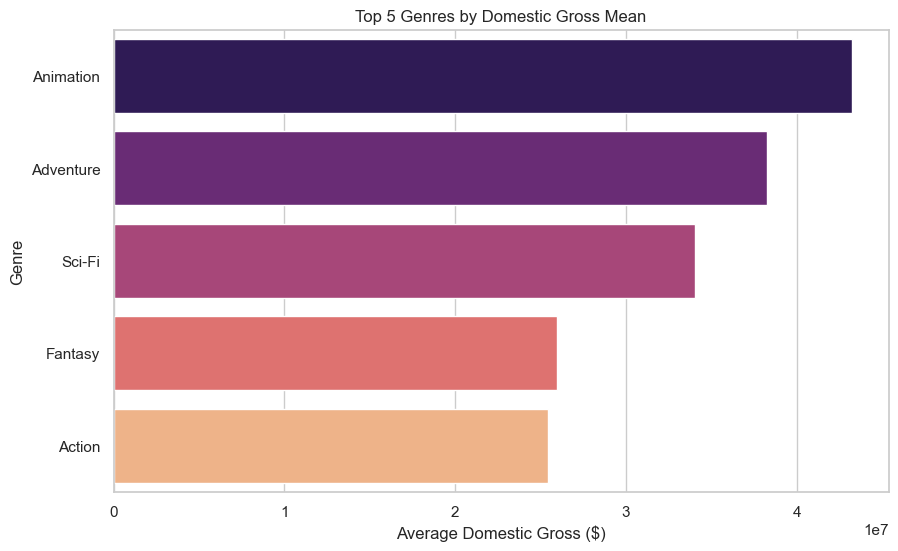

In [5]:
# Rename 'title' to 'primary_title' in bom_movie_gross for consistency
bom_movie_gross = bom_movie_gross.rename(columns={'title': 'primary_title'})

tn_movie_budgets = tn_movie_budgets.rename(columns={'movie': 'primary_title'})


# Merge unique_ratings with bom_movie_gross and then with tn_movie_budgets
merged_df = pd.merge(unique_ratings, bom_movie_gross[['primary_title']], on='primary_title', how='left')
final_merged_df = pd.merge(merged_df, tn_movie_budgets[['primary_title', 'production_budget', 'domestic_gross', 'worldwide_gross']],
                           on='primary_title', how='left')

# Filter out 'Unknown' genre entries after filling missing values but before splitting
final_merged_df['genres'] = final_merged_df['genres'].fillna('Unknown')
final_merged_df = final_merged_df[final_merged_df['genres'] != 'Unknown']

# Set display options to suppress scientific notation
pd.set_option('display.float_format', '{:.1f}'.format)

# Convert currency columns from string to float and calculate ROI
for column in ['production_budget', 'domestic_gross', 'worldwide_gross']:
    final_merged_df[column] = final_merged_df[column].replace('[\$,]', '', regex=True).astype(float)

final_merged_df['ROI Domestic'] = (final_merged_df['domestic_gross'] / final_merged_df['production_budget']) * 100
final_merged_df['ROI Worldwide'] = (final_merged_df['worldwide_gross'] / final_merged_df['production_budget']) * 100

# Handle duplicates and missing values
final_merged_df = final_merged_df.drop_duplicates(subset=['primary_title', 'primary_name'])
final_merged_df = final_merged_df.dropna(subset=['production_budget', 'domestic_gross', 'worldwide_gross'])

# Split genres and count them
final_merged_df['genres'] = final_merged_df['genres'].apply(lambda x: x.split(',') if isinstance(x, str) else ['Unknown'])
final_merged_df['genre_count'] = final_merged_df['genres'].apply(len)

# Explode genres for detailed analysis
exploded_df = final_merged_df.explode('genres')

# Apply weights to monetary fields
for column in ['production_budget', 'domestic_gross', 'worldwide_gross']:
    exploded_df[f'{column}_weighted'] = exploded_df[column] / exploded_df['genre_count']

# Aggregate the weighted data
aggregated_df = exploded_df.groupby('genres').agg({
    'production_budget_weighted': ['sum', 'mean'],
    'domestic_gross_weighted': ['sum', 'mean'],
    'worldwide_gross_weighted': ['sum', 'mean'],
    'ROI Domestic': 'mean',
    'ROI Worldwide': 'mean'
}).reset_index()

# Simplify column names
aggregated_df.columns = ['_'.join(col).strip() for col in aggregated_df.columns.values]

# Display the results
Worldwide_genre = aggregated_df.sort_values(by='ROI Worldwide_mean', ascending=False)[['genres_', 'ROI Worldwide_mean', 'worldwide_gross_weighted_sum', 'worldwide_gross_weighted_mean']].head(10)
Domestic_genre = aggregated_df.sort_values(by='ROI Domestic_mean', ascending=False)[['genres_', 'ROI Domestic_mean', 'domestic_gross_weighted_sum', 'domestic_gross_weighted_mean']].head(10)
Worldwide_gross_mean = aggregated_df.sort_values(by='worldwide_gross_weighted_mean', ascending=False)[['genres_', 'worldwide_gross_weighted_mean', 'ROI Worldwide_mean', 'worldwide_gross_weighted_sum']].head(10)
Domestic_gross_mean = aggregated_df.sort_values(by='domestic_gross_weighted_mean', ascending=False)[['genres_', 'domestic_gross_weighted_mean', 'ROI Domestic_mean', 'domestic_gross_weighted_sum']].head(10)

# Top 5 Worldwide ROI
plt.figure(figsize=(10, 6))
sns.barplot(x='ROI Worldwide_mean', y='genres_', data=Worldwide_genre.head(5), palette='cool')
plt.title('Top 5 Genres by Worldwide ROI')
plt.xlabel('Average ROI (%)')
plt.ylabel('Genre')
plt.show()

# Top 5 Domestic ROI
plt.figure(figsize=(10, 6))
sns.barplot(x='ROI Domestic_mean', y='genres_', data=Domestic_genre.head(5), palette='autumn')
plt.title('Top 5 Genres by Domestic ROI')
plt.xlabel('Average ROI (%)')
plt.ylabel('Genre')
plt.show()

# Top 5 Genres by Worldwide Gross Mean
plt.figure(figsize=(10, 6))
sns.barplot(x='worldwide_gross_weighted_mean', y='genres_', data=Worldwide_gross_mean.head(5), palette='viridis')
plt.title('Top 5 Genres by Worldwide Gross Mean')
plt.xlabel('Average Worldwide Gross ($)')
plt.ylabel('Genre')
plt.show()

# Top 5 Genres by Domestic Gross Mean
plt.figure(figsize=(10, 6))
sns.barplot(x='domestic_gross_weighted_mean', y='genres_', data=Domestic_gross_mean.head(5), palette='magma')
plt.title('Top 5 Genres by Domestic Gross Mean')
plt.xlabel('Average Domestic Gross ($)')
plt.ylabel('Genre')
plt.show()




## Correlation Insights

### ROI vs. Gross Mean
- The correlation between ROI and gross earnings varies by genre. While genres like **Mystery** and **Horror** show high ROI due to low production costs and good earnings, big-budget genres like **Animation** and **Adventure** dominate in gross terms but may not always reflect similar ROI percentages.

### Market Dependence
- Genres such as **Documentary** show a higher ROI domestically, indicating a specific cultural or regional appeal that may not translate as well on the global stage.

### Investment vs. Return
- High investment genres like **Sci-Fi** and **Adventure** usually garner significant gross earnings but their ROI is dependent on their blockbuster nature and wide appeal. Lower-cost genres like **Horror** can achieve high ROI on smaller budgets, which is a key strategy for many studios.


## Strategic Recommendations for Film Industry Stakeholders

### 1. Focus on Genre-Specific Investment Strategies
- **Low-Cost, High-ROI Genres:** Stakeholders should consider prioritizing investment in genres like Mystery and Horror. These genres typically require lower production costs and have demonstrated consistently high ROIs, both domestically and internationally. This strategy is particularly beneficial for independent studios or those with limited budgets.
- **High Investment for Broader Markets:** For major studios, continuing to invest in high-budget genres such as Animation, Adventure, and Sci-Fi can be advantageous. These genres often require substantial budgets but are proven to perform exceptionally well in terms of worldwide gross, appealing to broad and diverse audiences.

### 2. Leverage Market-Specific Insights
- **Tailoring Content to Regional Preferences:** Genres like Documentary, which show higher ROI in domestic markets, indicate a strong regional or cultural resonance. Stakeholders should consider developing content that is tailored to specific cultural or regional tastes and preferences, which could include localized storytelling elements or themes that resonate with domestic audiences.
- **Global Expansion for Popular Genres:** As genres like Animation and Adventure perform well worldwide, expanding their distribution and marketing efforts globally can capitalize on their universal appeal. This may include strategic release dates, extensive marketing campaigns, and collaborations with international studios.


## Analysis 2: Find ROI for Highest Grossing Films based on Directors

Moving forward, we will analyze the correlation between Director choice and film revenue/Return on Investment.  Does a films success and success at the box office vary based on who directs the film? Does a higher-profile director automatiaclly result in higher film profits, or does it also result in higher production budgets thus lowering the potential ROI? These questions will be answered in the upcoming analysis.

First, we want to start out by identifying which datasets we want to use in order to conduct this analysis.  I will be using tn_movie_budgets, directors_df (which is a new dataset I pulled showing all Academy Award winning categories, from which I will specifically pull Directors), and the unique_ratings dataframe we created through our SQL queries.  Using these dataframes, I will pull the means in order to further analyze the difference between Gross Revenue and Return on Investment for Academy Award Winning and nominated directors vs non oscar nominated or winning directors (captured in the database).

In [21]:
# Merge DataFrames on 'film' column from directors_df, corresponding to 'primary_title' in tn_movie_budgets
merj_df = tn_movie_budgets.merge(
    directors_df[['category', 'name', 'film', 'winner']],
    left_on='primary_title',
    right_on='film'
)

# Filter the rows where the category is 'DIRECTING'
merj_df = merj_df[merj_df['category'] == 'DIRECTING']

merj_df['production_budget'] = merj_df['production_budget'].replace('[\$,]', '', regex=True).astype('int64')
merj_df['domestic_gross'] = merj_df['domestic_gross'].replace('[\$,]', '', regex=True).astype('int64')
merj_df['worldwide_gross'] = merj_df['worldwide_gross'].replace('[\$,]', '', regex=True).astype('int64')


# Calculate ROI for Domestic and Worldwide
merj_df['ROI_Domestic'] = ((merj_df['domestic_gross'] - merj_df['production_budget']) / merj_df['production_budget']) * 100
merj_df['ROI_Worldwide'] = ((merj_df['worldwide_gross'] - merj_df['production_budget']) / merj_df['production_budget']) * 100

# Drop the 'id' column
merj_df.drop(columns=['id'], inplace=True)

# Reorder columns to move ROI columns after 'worldwide_gross'
new_column_order = ['release_date', 'primary_title', 'production_budget', 'domestic_gross', 'worldwide_gross',
                    'ROI_Domestic', 'ROI_Worldwide', 'category', 'name', 'film', 'winner']

merj_df = merj_df[new_column_order]


# Filter for Oscar-winning/nominated directors
oscar_directors_df = merj_df[merj_df['category'] == 'DIRECTING']



oscar_film_titles = oscar_directors_df['film'].unique()
non_oscar_directors_df = tn_movie_budgets[~tn_movie_budgets['primary_title'].isin(oscar_film_titles)]

# Calculate means for Oscar-winning/nominated directors
mean_oscar_production_budget = oscar_directors_df['production_budget'].mean()
mean_oscar_domestic_gross = oscar_directors_df['domestic_gross'].mean()
mean_oscar_worldwide_gross = oscar_directors_df['worldwide_gross'].mean()
mean_oscar_roi_domestic = oscar_directors_df['ROI_Domestic'].mean()
mean_oscar_roi_worldwide = oscar_directors_df['ROI_Worldwide'].mean()

# Display results for Oscar-winning/nominated directors
print(f"Mean Oscar Production Budget: ${mean_oscar_production_budget:,.2f}")
print(f"Mean Oscar Domestic Gross: ${mean_oscar_domestic_gross:,.2f}")
print(f"Mean Oscar Worldwide Gross: ${mean_oscar_worldwide_gross:,.2f}")
print(f"Mean Oscar Domestic ROI: {mean_oscar_roi_domestic:.2f}%")
print(f"Mean Oscar Worldwide ROI: {mean_oscar_roi_worldwide:.2f}%\n")

# Calculate means for non-Oscar-winning/nominated directors
mean_non_oscar_production_budget = non_oscar_directors_df['production_budget'].mean()
mean_non_oscar_domestic_gross = non_oscar_directors_df['domestic_gross'].mean()
mean_non_oscar_worldwide_gross = non_oscar_directors_df['worldwide_gross'].mean()
non_oscar_domestic_roi = ((mean_non_oscar_domestic_gross - mean_non_oscar_production_budget) / mean_non_oscar_production_budget) * 100
non_oscar_worldwide_roi = ((mean_non_oscar_worldwide_gross - mean_non_oscar_production_budget) / mean_non_oscar_production_budget) * 100

# Display results for non-Oscar-winning/nominated directors
print(f"Mean Non-Oscar Production Budget: ${mean_non_oscar_production_budget:,.2f}")
print(f"Mean Non-Oscar Domestic Gross: ${mean_non_oscar_domestic_gross:,.2f}")
print(f"Mean Non-Oscar Worldwide Gross: ${mean_non_oscar_worldwide_gross:,.2f}")
print(f"Mean Non-Oscar Domestic ROI: {non_oscar_domestic_roi:.2f}%")
print(f"Mean Non-Oscar Worldwide ROI: {non_oscar_worldwide_roi:.2f}%")




Mean Oscar Production Budget: $29,166,393.90
Mean Oscar Domestic Gross: $76,839,880.55
Mean Oscar Worldwide Gross: $164,611,566.39
Mean Oscar Domestic ROI: 573.37%
Mean Oscar Worldwide ROI: 978.94%

Mean Non-Oscar Production Budget: $31,674,114.66
Mean Non-Oscar Domestic Gross: $40,527,417.70
Mean Non-Oscar Worldwide Gross: $88,643,480.71
Mean Non-Oscar Domestic ROI: 27.95%
Mean Non-Oscar Worldwide ROI: 179.86%


The above output displays the different categorical financial values we are measuring for both oscar winning diretor and non oscar winning director-ed films.  A visualization will be created below to better highlight the data.

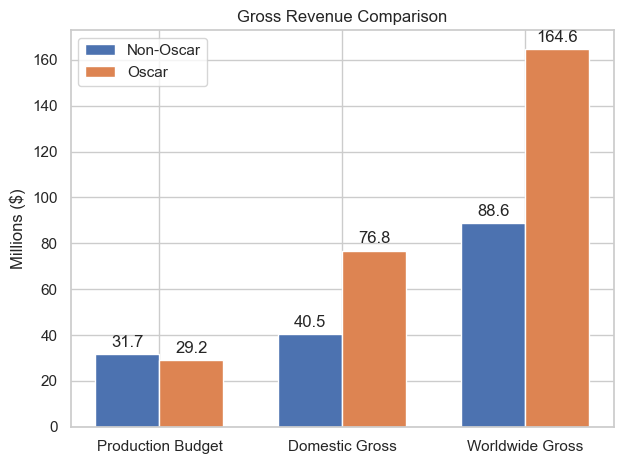

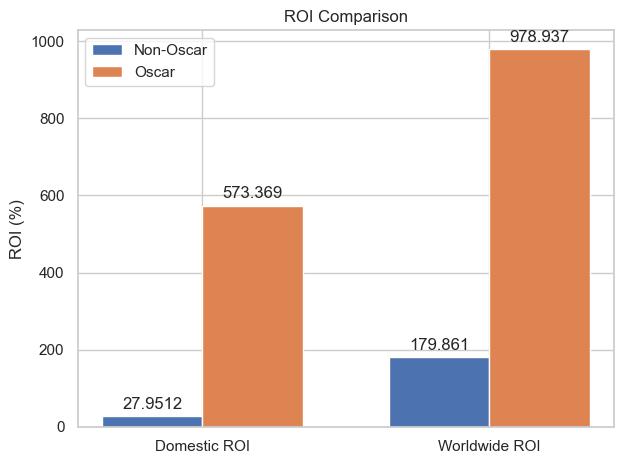

In [22]:
# Labels and data for the chart
labels = ['Production Budget', 'Domestic Gross', 'Worldwide Gross']
non_oscar_means = [mean_non_oscar_production_budget / 1e6, mean_non_oscar_domestic_gross / 1e6, mean_non_oscar_worldwide_gross / 1e6]
oscar_means = [mean_oscar_production_budget / 1e6, mean_oscar_domestic_gross / 1e6, mean_oscar_worldwide_gross / 1e6]

x = np.arange(len(labels))  # label locations
width = 0.35  # bar width

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, non_oscar_means, width, label='Non-Oscar')
rects2 = ax.bar(x + width/2, oscar_means, width, label='Oscar')

# Add text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Millions ($)')
ax.set_title('Gross Revenue Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Optionally add labels to the bars
ax.bar_label(rects1, padding=3, fmt='%.1f')
ax.bar_label(rects2, padding=3, fmt='%.1f')

fig.tight_layout()

plt.show()

# ROI comparison
labels = ['Domestic ROI', 'Worldwide ROI']
non_oscar_rois = [non_oscar_domestic_roi, non_oscar_worldwide_roi]
oscar_rois = [mean_oscar_roi_domestic, mean_oscar_roi_worldwide]

x = np.arange(len(labels))  # label locations
width = 0.35  # bar width

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, non_oscar_rois, width, label='Non-Oscar')
rects2 = ax.bar(x + width/2, oscar_rois, width, label='Oscar')

# Add text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('ROI (%)')
ax.set_title('ROI Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

#### Gross Revenue Comparison
- **Production Budget**: Films directed by Oscar-winning directors have a slightly lower average production budget ($29.2 million) compared to films directed by non-Oscar-winning directors ($31.7 million).
- **Domestic Gross**: Films directed by Oscar-winning directors earn significantly more in domestic gross ($76.8 million) compared to those directed by non-Oscar-winning directors ($40.5 million).
- **Worldwide Gross**: Films directed by Oscar-winning directors also perform substantially better in worldwide gross ($164.6 million) compared to those directed by non-Oscar-winning directors ($88.6 million).

#### ROI Comparison
- **Domestic ROI**: Films directed by Oscar-winning directors have a much higher average domestic ROI (573.369%) compared to those directed by non-Oscar-winning directors (27.9512%).
- **Worldwide ROI**: The worldwide ROI for films directed by Oscar-winning directors (978.937%) far exceeds that of films directed by non-Oscar-winning directors (179.861%).